#### Model Development considering features avaialbale during point of transaction

In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, learning_curve, GridSearchCV
from sklearn.metrics import average_precision_score, roc_curve, precision_recall_curve, confusion_matrix

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import time
import pickle

In [2]:
df_cot=pd.read_csv('/Users/Abhirup/Desktop/Projects/HSBC DS Assignment/df_cot.csv')
df_cot.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,time_of_day,amount_tod_median,amount_tod_std,amount_tod_max,amount_deviance_5,amount_deviance_6,amount_deviance_7,amount_deviance_8,diffBalanceOrig,diffBalanceDest
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,...,1,156986.25,375750.01,4407884.05,-0.42,-156805.25,4407703.05,1.00,0.00,181.0
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,...,1,156986.25,375750.01,4407884.05,-0.42,-156805.25,4407703.05,1.00,0.00,21363.0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,...,1,156986.25,375750.01,4407884.05,0.19,72147.69,4178750.11,0.95,213808.94,182703.5
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,...,1,156986.25,375750.01,4407884.05,0.16,58324.05,4192573.75,0.95,214605.30,237735.3
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,...,1,156986.25,375750.01,4407884.05,0.41,154699.64,4096198.16,0.93,300850.89,-2401220.0


In [3]:
print(df_cot.shape)
print(df_cot.dtypes)

(2770409, 35)
step                   int64
type                  object
amount               float64
nameOrig              object
oldBalanceOrig       float64
newBalanceOrig       float64
nameDest              object
oldBalanceDest       float64
newBalanceDest       float64
isFraud                int64
isFlaggedFraud         int64
week                   int64
$TransLW             float64
NumTransLW             int64
FraudBefore            int64
oldBalanceOrigCat      int64
amount_median        float64
amount_std           float64
amt_max              float64
amount_deviance_1    float64
amount_deviance_2    float64
amount_deviance_3    float64
amount_deviance_4    float64
amount_zero            int64
amt_bal_perc         float64
time_of_day            int64
amount_tod_median    float64
amount_tod_std       float64
amount_tod_max       float64
amount_deviance_5    float64
amount_deviance_6    float64
amount_deviance_7    float64
amount_deviance_8    float64
diffBalanceOrig      float64


In [4]:
df_cot.loc[df_cot['type']=='TRANSFER','trans_type']=1
df_cot.loc[df_cot['type']=='CASH_OUT','trans_type']=0
df_cot['trans_type']=df_cot['trans_type'].astype(int)
df_cot['trans_type'].value_counts()

0    2237500
1     532909
Name: trans_type, dtype: int64

In [5]:
#Creating a transaction ID
df_cot['tran_id']=df_cot.index +1
df_cot.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,amount_tod_std,amount_tod_max,amount_deviance_5,amount_deviance_6,amount_deviance_7,amount_deviance_8,diffBalanceOrig,diffBalanceDest,trans_type,tran_id
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,...,375750.01,4407884.05,-0.42,-156805.25,4407703.05,1.00,0.00,181.0,1,1
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,...,375750.01,4407884.05,-0.42,-156805.25,4407703.05,1.00,0.00,21363.0,0,2
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,...,375750.01,4407884.05,0.19,72147.69,4178750.11,0.95,213808.94,182703.5,0,3
3,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,...,375750.01,4407884.05,0.16,58324.05,4192573.75,0.95,214605.30,237735.3,1,4
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,...,375750.01,4407884.05,0.41,154699.64,4096198.16,0.93,300850.89,-2401220.0,1,5


In [6]:
# not including new balances assuming it gets updated post transaction
#,'diffBalanceOrig','diffBalanceDest'
feature_list=['NumTransLW','FraudBefore','oldBalanceOrigCat','amount_zero','time_of_day','amount','oldBalanceOrig'
              ,'oldBalanceDest','$TransLW','amount_median','amount_std','amt_max','amount_deviance_1'
              ,'amount_deviance_2','amount_deviance_3','amount_deviance_4','amt_bal_perc','amount_tod_median'
              ,'amount_tod_std','amount_tod_max','amount_deviance_5','amount_deviance_6','amount_deviance_7'
              ,'amount_deviance_8','trans_type']
variable_list=['tran_id','isFraud','NumTransLW','FraudBefore','oldBalanceOrigCat','amount_zero','time_of_day','amount'
               ,'oldBalanceOrig','oldBalanceDest','$TransLW','amount_median','amount_std','amt_max'
               ,'amount_deviance_1','amount_deviance_2','amount_deviance_3','amount_deviance_4','amt_bal_perc'
               ,'amount_tod_median','amount_tod_std','amount_tod_max','amount_deviance_5','amount_deviance_6'
               ,'amount_deviance_7','amount_deviance_8','diffBalanceOrig','diffBalanceDest','trans_type']

In [7]:
df_model_dev=df_cot.loc[df_cot['week'].isin([2,3]),variable_list]
df_oot_val=df_cot.loc[df_cot['week']==4,variable_list]
print(df_model_dev.shape)
print(df_oot_val.shape)
print(df_model_dev['isFraud'].value_counts())

(1697805, 29)
(81630, 29)
0    1693762
1       4043
Name: isFraud, dtype: int64


In [8]:
target='isFraud'
IDcol='tran_id'

label=df_model_dev[target]

#split data into train and test
seed=1234
test_size=0.3

X_train, X_test, Y_train, Y_test = train_test_split(df_model_dev[feature_list], 
                                                    label, test_size=test_size, random_state=seed,stratify=label)

In [9]:
print(round(Y_test.sum()/Y_train.sum()*100,2))
print(round(len(X_test)/len(X_train)*100),2)

42.86
43 2


In [27]:
xgb_vs_1 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=2000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=419,
 seed=27)

train_dm=xgb.DMatrix(X_train.values, label=Y_train)

start_time=time.time()

cvresult=xgb.cv(xgb_vs_1.get_xgb_params(), train_dm, num_boost_round=xgb_vs_1.get_params()['n_estimators'], nfold=5,
                metrics='aucpr', early_stopping_rounds=50)

print((time.time()-start_time)/60)

321.9937421361605


In [28]:
 cvresult.tail()

,train-aucpr-mean,train-aucpr-std,test-aucpr-mean,test-aucpr-std
1995,0.999961,0.000015,0.981830,0.001580
1996,0.999962,0.000014,0.981832,0.001584
1997,0.999962,0.000014,0.981823,0.001587
1998,0.999962,0.000014,0.981809,0.001586
1999,0.999962,0.000015,0.981810,0.001588


In [29]:
print(cvresult[cvresult['test-aucpr-mean'] == cvresult['test-aucpr-mean'].max()])
print(cvresult[cvresult['train-aucpr-mean'] == cvresult['train-aucpr-mean'].max()])

      train-aucpr-mean  train-aucpr-std  test-aucpr-mean  test-aucpr-std
1985          0.999957         0.000016         0.981832        0.001603
      train-aucpr-mean  train-aucpr-std  test-aucpr-mean  test-aucpr-std
1998          0.999962         0.000014         0.981809        0.001586


In [30]:
cvresult.shape[0]

2000

In [31]:
xgb_vs_f = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1986,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=419,
 seed=27)

In [32]:
train_df=df_model_dev.loc[X_train.index,:]
test_df=df_model_dev.loc[X_test.index,:]
print(train_df.shape)
print(test_df.shape)

(1188463, 29)
(509342, 29)


In [34]:
start_time=time.time()
xgb_vs_f.fit(train_df[feature_list], train_df[target],eval_metric= ['auc', 'aucpr'])
#pickle.dump(xgb_vs_f, open("xgb_model_1", "wb"))
print((time.time()-start_time)/60)

65.08188375234604


In [35]:
train_df['Prob_Score']=xgb_vs_f.predict_proba(train_df[feature_list])[:,1]
test_df['Prob_Score']=xgb_vs_f.predict_proba(test_df[feature_list])[:,1]
print('AUPRC Train= {}'.format(average_precision_score(train_df[target], train_df['Prob_Score'])))
print('AUPRC Test= {}'.format(average_precision_score(test_df[target], test_df['Prob_Score'])))

AUPRC Train= 0.9998533705902664
AUPRC Test= 0.9859702155974164


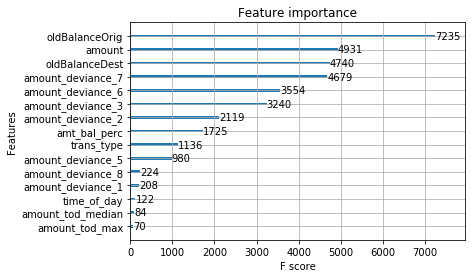

In [36]:
#Check Feature Importance
plot_importance(xgb_vs_f, max_num_features=15)
plt.show()

In [37]:
df_oot_val['Prob_Score']=xgb_vs_f.predict_proba(df_oot_val[feature_list])[:,1]
print('AUPRC OOT= {}'.format(average_precision_score(df_oot_val[target], df_oot_val['Prob_Score'])))

AUPRC OOT= 0.9915007387515792


In [38]:
precision, recall, thresholds = precision_recall_curve(train_df[target], train_df['Prob_Score'])

In [39]:
#Transaction Score
thresholds[np.argmax(precision)]

0.99918276

In [40]:
train_df.loc[train_df['Prob_Score']>=thresholds[np.argmax(precision)],'isFraud_Pred']=1
train_df.loc[train_df['Prob_Score']<thresholds[np.argmax(precision)],'isFraud_Pred']=0
train_df['isFraud_Pred']=train_df['isFraud_Pred'].astype(int)
train_df.head()

,tran_id,isFraud,NumTransLW,FraudBefore,oldBalanceOrigCat,amount_zero,time_of_day,amount,oldBalanceOrig,oldBalanceDest,...,amount_tod_max,amount_deviance_5,amount_deviance_6,amount_deviance_7,amount_deviance_8,diffBalanceOrig,diffBalanceDest,trans_type,Prob_Score,isFraud_Pred
2486318,2486319,0,0,0,2,0,2,140499.38,10575.0,620769.42,...,47504216.38,-0.09,-61928.34,47363717.00,1.0,129924.38,0.0,0,1.631039e-12,0
2212281,2212282,0,0,0,1,0,3,54612.50,0.0,884088.71,...,69886731.30,-0.12,-109859.74,69832118.80,1.0,54612.50,0.0,0,7.512916e-09,0
2121081,2121082,0,0,0,1,0,2,311824.10,0.0,2088728.46,...,92445516.64,0.12,140882.19,92133692.54,1.0,311824.10,0.0,0,1.112728e-09,0
1977064,1977065,0,0,0,3,0,2,33010.29,39725.0,303816.90,...,57787800.93,-0.21,-171613.69,57754790.64,1.0,0.00,0.0,0,3.355162e-06,0
1298699,1298700,0,0,0,1,0,2,150102.72,0.0,969143.65,...,92445516.64,-0.02,-20839.19,92295413.92,1.0,150102.72,0.0,0,5.461207e-08,0


In [41]:
cm1=confusion_matrix(train_df[target],train_df['isFraud_Pred'])
print('Confusion Matrix: \n',cm1)
total=sum(sum(cm1))
print("\nAccuracy: {}" .format(round(((cm1[0,0]+cm1[1,1])/total)*100,2)))
print("\nSensitivity/Recall/TPR: {}" .format(round((cm1[1,1]/(cm1[1,1]+cm1[1,0]))*100,2)))
print("\nPrecision: {}" .format(round((cm1[1,1]/(cm1[1,1]+cm1[0,1]))*100,2)))
print("\nSpecificity:" .format(round((cm1[0,0]/(cm1[0,0]+cm1[0,1]))*100,2)))

Confusion Matrix: 
 [[1185633       0]
 [    266    2564]]

Accuracy: 99.98

Sensitivity/Recall/TPR: 90.6

Precision: 100.0

Specificity:


In [42]:
test_df.loc[test_df['Prob_Score']>=thresholds[np.argmax(precision)],'isFraud_Pred']=1
test_df.loc[test_df['Prob_Score']<thresholds[np.argmax(precision)],'isFraud_Pred']=0
test_df['isFraud_Pred']=test_df['isFraud_Pred'].astype(int)
cm1=confusion_matrix(test_df[target],test_df['isFraud_Pred'])
print('Confusion Matrix: \n',cm1)
total=sum(sum(cm1))
print("\nAccuracy: {}" .format(round(((cm1[0,0]+cm1[1,1])/total)*100,2)))
print("\nSensitivity/Recall/TPR: {}" .format(round((cm1[1,1]/(cm1[1,1]+cm1[1,0]))*100,2)))
print("\nPrecision: {}" .format(round((cm1[1,1]/(cm1[1,1]+cm1[0,1]))*100,2)))
print("\nSpecificity:" .format(round((cm1[0,0]/(cm1[0,0]+cm1[0,1]))*100,2)))

Confusion Matrix: 
 [[508128      1]
 [   163   1050]]

Accuracy: 99.97

Sensitivity/Recall/TPR: 86.56

Precision: 99.9

Specificity:


In [43]:
df_oot_val.loc[df_oot_val['Prob_Score']>=thresholds[np.argmax(precision)],'isFraud_Pred']=1
df_oot_val.loc[df_oot_val['Prob_Score']<thresholds[np.argmax(precision)],'isFraud_Pred']=0
df_oot_val['isFraud_Pred']=df_oot_val['isFraud_Pred'].astype(int)
cm1=confusion_matrix(df_oot_val[target],df_oot_val['isFraud_Pred'])
print('Confusion Matrix: \n',cm1)
total=sum(sum(cm1))
print("\nAccuracy: {}" .format(round(((cm1[0,0]+cm1[1,1])/total)*100,2)))
print("\nSensitivity/Recall/TPR: {}" .format(round((cm1[1,1]/(cm1[1,1]+cm1[1,0]))*100,2)))
print("\nPrecision: {}" .format(round((cm1[1,1]/(cm1[1,1]+cm1[0,1]))*100,2)))
print("\nSpecificity:" .format(round((cm1[0,0]/(cm1[0,0]+cm1[0,1]))*100,2)))

Confusion Matrix: 
 [[79582     0]
 [  358  1690]]

Accuracy: 99.56

Sensitivity/Recall/TPR: 82.52

Precision: 100.0

Specificity:


In [44]:
pickle.dump(xgb_vs_f, open("xgb_model_1.2", "wb"))